Device: cuda


/tmp/ipython-input-552444568.py:271: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.enc = nn.TransformerEncoder(enc_layer, num_layers=cfg.n_layers)


Model params: 0.64M
Events/step=15, topK=8, seq_len=48, batch=64
step    1  loss 22.0214  salience v:0.331 a:0.591 t:0.066 f:0.012 g:0.000
step   25  loss 14.7037  salience v:0.331 a:0.590 t:0.065 f:0.013 g:0.000
step   50  loss 14.4542  salience v:0.334 a:0.587 t:0.066 f:0.013 g:0.000
step   75  loss 14.3391  salience v:0.335 a:0.587 t:0.066 f:0.012 g:0.000
val  vision 0.019 ░░░░░░░░░░░░░░░░░░  audio 0.028 █░░░░░░░░░░░░░░░░░
     text   0.796 ██████████████░░░░  feeling 0.739 █████████████░░░░░  goal 0.034 █░░░░░░░░░░░░░░░░░
step  100  loss 13.8613  salience v:0.337 a:0.579 t:0.070 f:0.014 g:0.000
step  125  loss 13.6081  salience v:0.331 a:0.584 t:0.067 f:0.017 g:0.000
step  150  loss 13.0563  salience v:0.334 a:0.585 t:0.067 f:0.014 g:0.000
val  vision 0.034 █░░░░░░░░░░░░░░░░░  audio 0.044 █░░░░░░░░░░░░░░░░░
     text   0.798 ██████████████░░░░  feeling 0.760 ██████████████░░░░  goal 0.232 ████░░░░░░░░░░░░░░
step  175  loss 12.0284  salience v:0.334 a:0.580 t:0.072 f:0.014 g:0.000
s

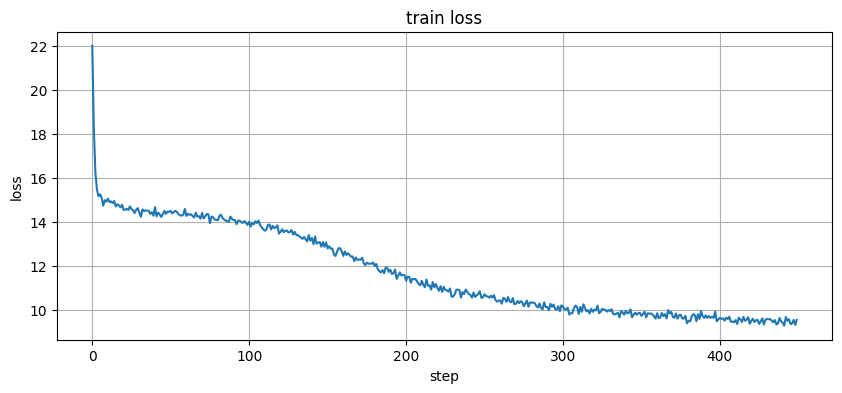

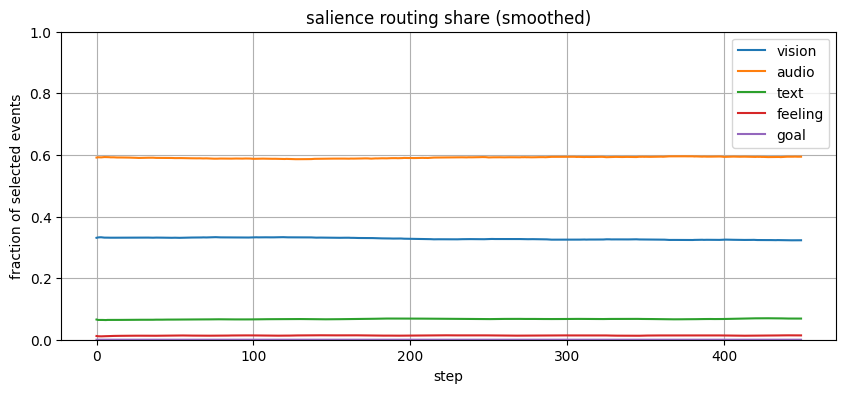

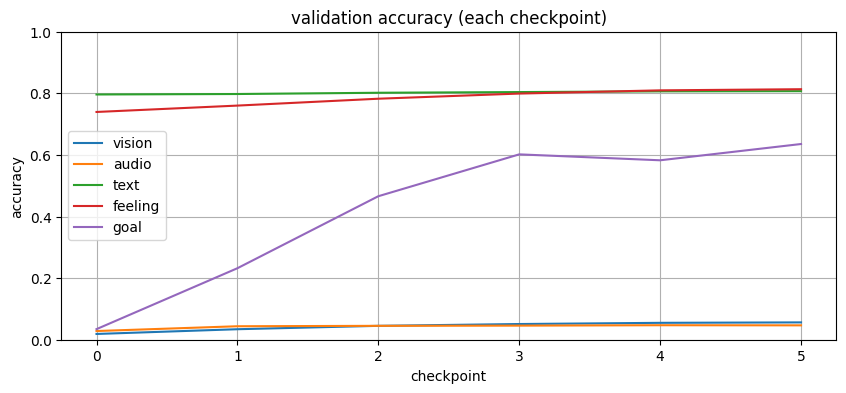


rollout (teacher forcing, show next-step predictions)
columns: t | goal_lat | obj_lat | mood_lat | pred_goal | pred_text_nonzero | salience_share
00 | 10 | 02 | -1.00 | 23 | 0 | v0.38 a0.38 t0.12 f0.12 g0.00
01 | 10 | 12 | -1.85 | 09 | 0 | v0.38 a0.62 t0.00 f0.00 g0.00
02 | 10 | 11 | -2.70 | 09 | 0 | v0.25 a0.62 t0.12 f0.00 g0.00
03 | 10 | 10 | -1.55 | 10 | 0 | v0.38 a0.50 t0.12 f0.00 g0.00
04 | 10 | 10 | -0.40 | 10 | 0 | v0.38 a0.62 t0.00 f0.00 g0.00
05 | 10 | 10 |  0.45 | 10 | 0 | v0.38 a0.62 t0.00 f0.00 g0.00
06 | 10 | 10 |  1.45 | 10 | 0 | v0.12 a0.88 t0.00 f0.00 g0.00
07 | 10 | 10 |  2.60 | 10 | 0 | v0.38 a0.62 t0.00 f0.00 g0.00
08 | 10 | 12 |  1.45 | 10 | 0 | v0.38 a0.62 t0.00 f0.00 g0.00
09 | 10 | 11 |  0.45 | 10 | 0 | v0.25 a0.62 t0.12 f0.00 g0.00
10 | 10 | 10 |  1.60 | 10 | 0 | v0.38 a0.62 t0.00 f0.00 g0.00
11 | 10 | 10 |  2.60 | 10 | 0 | v0.25 a0.75 t0.00 f0.00 g0.00
12 | 10 | 10 |  3.75 | 10 | 0 | v0.12 a0.75 t0.12 f0.00 g0.00
13 | 10 | 10 |  4.00 | 10 | 0 | v0.38 a0.50 t0.

In [1]:
# Brain inspired multimodal prototype
# Runs in Google Colab in one cell.
# What you get:
# - Unified event stream per timestep (vision, audio, text, feeling, goal)
# - Modality ids + slot ids + timestamp embeddings
# - Recurrent compressed world_state (GRU)
# - Salience gating top-K events per step
# - Next-step prediction for all modalities
# - Clean console logs + plots + validation

import math
import random
from dataclasses import dataclass
from typing import Dict, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# ---------------------------
# Pretty console helpers
# ---------------------------

class C:
    B = "\033[1m"
    DIM = "\033[2m"
    G = "\033[92m"
    Y = "\033[93m"
    C = "\033[96m"
    R = "\033[91m"
    M = "\033[95m"
    END = "\033[0m"

def bar(p: float, width: int = 18) -> str:
    p = max(0.0, min(1.0, p))
    n = int(round(p * width))
    return "█" * n + "░" * (width - n)

def fmt(n: float, digits: int = 4) -> str:
    return f"{n:.{digits}f}"


# ---------------------------
# Repro
# ---------------------------

def set_seed(seed: int = 7):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(7)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{C.C}{C.B}Device{C.END}: {device}")


# ---------------------------
# Config
# ---------------------------

@dataclass
class Vocab:
    vision: int = 64
    audio: int = 64
    text: int = 128
    feeling: int = 16
    goal: int = 32

@dataclass
class Shape:
    vision_n: int = 4
    audio_n: int = 8
    text_n: int = 1
    feeling_n: int = 1
    goal_n: int = 1

    @property
    def events_per_step(self) -> int:
        return self.vision_n + self.audio_n + self.text_n + self.feeling_n + self.goal_n

@dataclass
class ModelCfg:
    d_model: int = 128
    nhead: int = 4
    n_layers: int = 2
    ff_mult: int = 4
    dropout: float = 0.1
    max_time: int = 256
    top_k: int = 8   # salience gating, per step

@dataclass
class TrainCfg:
    batch_size: int = 64
    seq_len: int = 48
    steps: int = 450
    lr: float = 2e-3
    grad_clip: float = 1.0
    log_every: int = 25
    val_every: int = 75


VOC = Vocab()
SHP = Shape()
MCFG = ModelCfg()
TCFG = TrainCfg()


# ---------------------------
# Synthetic multimodal environment
# ---------------------------

class SyntheticWorld:
    """
    Creates predictable cross-modal streams using hidden latents:
    - object_id (drifts)
    - goal_id (changes slowly)
    - mood (improves when object matches goal)
    Modal tokens are deterministic-ish functions of these latents + small noise.
    """

    def __init__(self, voc: Vocab, shp: Shape, n_objects: int = 24):
        self.voc = voc
        self.shp = shp
        self.n_objects = n_objects

    def _step_latents(self, obj: torch.Tensor, goal: torch.Tensor, mood: torch.Tensor, t: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        B = obj.shape[0]

        # goal changes every ~12 steps with some probability
        if t % 12 == 0:
            change = torch.rand(B, device=obj.device) < 0.35
            new_goal = torch.randint(0, self.voc.goal, (B,), device=obj.device)
            goal = torch.where(change, new_goal, goal)

        # object drifts toward goal (a simple "tracking" dynamic)
        toward = torch.rand(B, device=obj.device) < 0.60
        delta = torch.sign(goal.to(torch.int64) - obj.to(torch.int64)).to(obj.dtype)
        obj = torch.where(toward, (obj + delta) % self.n_objects, obj)

        # occasional random jump
        jump = torch.rand(B, device=obj.device) < 0.08
        obj = torch.where(jump, torch.randint(0, self.n_objects, (B,), device=obj.device), obj)

        # mood: up when obj matches goal, down otherwise, plus tiny noise
        hit = (obj % self.voc.goal) == goal
        mood = mood + hit.to(mood.dtype) - (~hit).to(mood.dtype)
        mood = mood + torch.randint(-1, 2, (B,), device=obj.device).to(mood.dtype) * 0.15
        mood = mood.clamp(-4.0, 4.0)
        return obj, goal, mood

    def generate_batch(self, batch_size: int, seq_len: int, device: torch.device) -> Dict[str, torch.Tensor]:
        B, T = batch_size, seq_len

        obj = torch.randint(0, self.n_objects, (B,), device=device)
        goal = torch.randint(0, self.voc.goal, (B,), device=device)
        mood = torch.zeros(B, device=device)

        vision = torch.zeros(B, T, self.shp.vision_n, dtype=torch.long, device=device)
        audio = torch.zeros(B, T, self.shp.audio_n, dtype=torch.long, device=device)
        text = torch.zeros(B, T, self.shp.text_n, dtype=torch.long, device=device)
        feeling = torch.zeros(B, T, self.shp.feeling_n, dtype=torch.long, device=device)
        goal_tok = torch.zeros(B, T, self.shp.goal_n, dtype=torch.long, device=device)

        obj_track = torch.zeros(B, T, dtype=torch.long, device=device)
        goal_track = torch.zeros(B, T, dtype=torch.long, device=device)
        mood_track = torch.zeros(B, T, dtype=torch.float, device=device)

        for t in range(T):
            obj, goal, mood = self._step_latents(obj, goal, mood, t)

            obj_track[:, t] = obj
            goal_track[:, t] = goal
            mood_track[:, t] = mood

            # Vision: patch tokens encode object id with patch index, light noise
            for p in range(self.shp.vision_n):
                v = (obj * 3 + p * 7 + torch.randint(0, 3, (B,), device=device)) % self.voc.vision
                vision[:, t, p] = v

            # Audio: encode object+goal interaction, more bandwidth, light noise
            for a in range(self.shp.audio_n):
                base = (obj * 5 + goal * 2 + a * 3) % self.voc.audio
                n = torch.randint(0, 4, (B,), device=device)
                audio[:, t, a] = (base + n) % self.voc.audio

            # Text: occasional "labeling" token correlated with object and goal
            # make it sparse like language in a perception stream
            speak = (torch.rand(B, device=device) < 0.18) | (t % 16 == 0)
            txt = (obj * 11 + goal * 13) % self.voc.text
            text[:, t, 0] = torch.where(speak, txt, torch.zeros_like(txt))

            # Feeling: quantize mood into 16 bins
            f = ((mood + 4.0) * (self.voc.feeling - 1) / 8.0).round().long().clamp(0, self.voc.feeling - 1)
            feeling[:, t, 0] = f

            # Goal token: always present, internal synthetic signal
            goal_tok[:, t, 0] = goal

        return {
            "vision": vision,
            "audio": audio,
            "text": text,
            "feeling": feeling,
            "goal": goal_tok,
            "obj": obj_track,
            "goal_lat": goal_track,
            "mood": mood_track,
        }


WORLD = SyntheticWorld(VOC, SHP).generate_batch


# ---------------------------
# Model: salience + transformer + recurrent world_state + multimodal heads
# ---------------------------

class SalienceGate(nn.Module):
    def __init__(self, d: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(d),
            nn.Linear(d, d),
            nn.GELU(),
            nn.Linear(d, 1),
        )

    def forward(self, x: torch.Tensor, k: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # x: [B, E, D]
        scores = self.net(x).squeeze(-1)  # [B, E]
        idx = torch.topk(scores, k=k, dim=1).indices  # [B, K]
        picked = x.gather(1, idx.unsqueeze(-1).expand(-1, -1, x.size(-1)))  # [B, K, D]
        return picked, idx


class BrainishModel(nn.Module):
    def __init__(self, voc: Vocab, shp: Shape, cfg: ModelCfg):
        super().__init__()
        self.voc = voc
        self.shp = shp
        self.cfg = cfg

        self.n_modal = 5  # vision, audio, text, feeling, goal
        self.total_slots = shp.events_per_step

        # Token embeddings per modality (keeps prototype clean and extendable)
        self.emb_vision = nn.Embedding(voc.vision, cfg.d_model)
        self.emb_audio = nn.Embedding(voc.audio, cfg.d_model)
        self.emb_text = nn.Embedding(voc.text, cfg.d_model)
        self.emb_feeling = nn.Embedding(voc.feeling, cfg.d_model)
        self.emb_goal = nn.Embedding(voc.goal, cfg.d_model)

        self.mod_emb = nn.Embedding(self.n_modal, cfg.d_model)
        self.slot_emb = nn.Embedding(self.total_slots, cfg.d_model)
        self.time_emb = nn.Embedding(cfg.max_time, cfg.d_model)

        self.salience = SalienceGate(cfg.d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model,
            nhead=cfg.nhead,
            dim_feedforward=cfg.d_model * cfg.ff_mult,
            dropout=cfg.dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=cfg.n_layers)

        self.state_proj = nn.Linear(cfg.d_model, cfg.d_model)
        self.state_upd = nn.GRUCell(cfg.d_model, cfg.d_model)

        # Heads: world_state + per-slot embeddings -> logits
        self.head_v = nn.Linear(cfg.d_model, voc.vision)
        self.head_a = nn.Linear(cfg.d_model, voc.audio)
        self.head_t = nn.Linear(cfg.d_model, voc.text)
        self.head_f = nn.Linear(cfg.d_model, voc.feeling)
        self.head_g = nn.Linear(cfg.d_model, voc.goal)

        self.out_slot_v = nn.Embedding(shp.vision_n, cfg.d_model)
        self.out_slot_a = nn.Embedding(shp.audio_n, cfg.d_model)
        self.out_slot_t = nn.Embedding(shp.text_n, cfg.d_model)
        self.out_slot_f = nn.Embedding(shp.feeling_n, cfg.d_model)
        self.out_slot_g = nn.Embedding(shp.goal_n, cfg.d_model)

        self.norm_state = nn.LayerNorm(cfg.d_model)

    def init_state(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.cfg.d_model, device=device)

    def _embed_step(self, tokens: Dict[str, torch.Tensor], t: int) -> torch.Tensor:
        # Build [B, E, D] unified event embeddings with modality + slot + time
        B = tokens["vision"].size(0)
        time = torch.full((B,), t, device=tokens["vision"].device, dtype=torch.long) % self.cfg.max_time
        te = self.time_emb(time)  # [B, D]

        # slot layout: [vision slots][audio slots][text][feeling][goal]
        parts = []
        slot = 0

        v = self.emb_vision(tokens["vision"])  # [B, Vn, D]
        v = v + self.mod_emb(torch.full((self.shp.vision_n,), 0, device=v.device)).unsqueeze(0)
        v = v + self.slot_emb(torch.arange(slot, slot + self.shp.vision_n, device=v.device)).unsqueeze(0)
        v = v + te.unsqueeze(1)
        parts.append(v)
        slot += self.shp.vision_n

        a = self.emb_audio(tokens["audio"])  # [B, An, D]
        a = a + self.mod_emb(torch.full((self.shp.audio_n,), 1, device=a.device)).unsqueeze(0)
        a = a + self.slot_emb(torch.arange(slot, slot + self.shp.audio_n, device=a.device)).unsqueeze(0)
        a = a + te.unsqueeze(1)
        parts.append(a)
        slot += self.shp.audio_n

        tt = self.emb_text(tokens["text"])  # [B, 1, D]
        tt = tt + self.mod_emb(torch.tensor([2], device=tt.device)).unsqueeze(0)
        tt = tt + self.slot_emb(torch.tensor([slot], device=tt.device)).unsqueeze(0)
        tt = tt + te.unsqueeze(1)
        parts.append(tt)
        slot += 1

        ff = self.emb_feeling(tokens["feeling"])  # [B, 1, D]
        ff = ff + self.mod_emb(torch.tensor([3], device=ff.device)).unsqueeze(0)
        ff = ff + self.slot_emb(torch.tensor([slot], device=ff.device)).unsqueeze(0)
        ff = ff + te.unsqueeze(1)
        parts.append(ff)
        slot += 1

        gg = self.emb_goal(tokens["goal"])  # [B, 1, D]
        gg = gg + self.mod_emb(torch.tensor([4], device=gg.device)).unsqueeze(0)
        gg = gg + self.slot_emb(torch.tensor([slot], device=gg.device)).unsqueeze(0)
        gg = gg + te.unsqueeze(1)
        parts.append(gg)

        x = torch.cat(parts, dim=1)  # [B, E, D]
        return x

    def _predict_next(self, state: torch.Tensor) -> Dict[str, torch.Tensor]:
        # state: [B, D]
        B = state.size(0)
        s = self.norm_state(state)

        def slot_logits(slot_emb: nn.Embedding, head: nn.Linear, n: int):
            idx = torch.arange(n, device=state.device)
            q = s.unsqueeze(1) + slot_emb(idx).unsqueeze(0)  # [B, n, D]
            return head(q)  # [B, n, vocab]

        return {
            "vision": slot_logits(self.out_slot_v, self.head_v, self.shp.vision_n),
            "audio": slot_logits(self.out_slot_a, self.head_a, self.shp.audio_n),
            "text": slot_logits(self.out_slot_t, self.head_t, self.shp.text_n),
            "feeling": slot_logits(self.out_slot_f, self.head_f, self.shp.feeling_n),
            "goal": slot_logits(self.out_slot_g, self.head_g, self.shp.goal_n),
        }

    def forward_step(self, tokens_t: Dict[str, torch.Tensor], state: torch.Tensor, t: int) -> Tuple[Dict[str, torch.Tensor], torch.Tensor, torch.Tensor]:
        # tokens_t: per modality tokens at time t (one step)
        # state: [B, D]
        x = self._embed_step(tokens_t, t)  # [B, E, D]

        # Salience: pick top-K events to forward
        picked, idx = self.salience(x, k=min(self.cfg.top_k, x.size(1)))  # [B, K, D]

        # World token uses recurrent state
        world_tok = self.state_proj(state).unsqueeze(1)  # [B, 1, D]
        seq = torch.cat([world_tok, picked], dim=1)  # [B, 1+K, D]

        h = self.enc(seq)  # [B, 1+K, D]
        world_rep = h[:, 0]  # [B, D]

        # Update state
        new_state = self.state_upd(world_rep, state)  # [B, D]

        # Predict tokens for time t+1
        logits = self._predict_next(new_state)
        return logits, new_state, idx


# ---------------------------
# Loss + metrics
# ---------------------------

def ce_loss(logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # logits: [B, N, V], target: [B, N]
    B, N, V = logits.shape
    return F.cross_entropy(logits.reshape(B * N, V), target.reshape(B * N))

@torch.no_grad()
def accuracy(logits: torch.Tensor, target: torch.Tensor) -> float:
    pred = logits.argmax(dim=-1)
    return (pred == target).float().mean().item()


def step_batch_to_tokens(batch: Dict[str, torch.Tensor], t: int) -> Dict[str, torch.Tensor]:
    return {
        "vision": batch["vision"][:, t, :],
        "audio": batch["audio"][:, t, :],
        "text": batch["text"][:, t, :],
        "feeling": batch["feeling"][:, t, :],
        "goal": batch["goal"][:, t, :],
    }


# ---------------------------
# Training + validation
# ---------------------------

@torch.no_grad()
def run_eval(model: BrainishModel, batch_size: int = 128, seq_len: int = 64, seed: int = 999) -> Dict[str, float]:
    set_seed(seed)
    model.eval()
    batch = WORLD(batch_size, seq_len, device)
    state = model.init_state(batch_size, device)

    accs = {"vision": 0.0, "audio": 0.0, "text": 0.0, "feeling": 0.0, "goal": 0.0}
    count = 0

    for t in range(seq_len - 1):
        tokens_t = step_batch_to_tokens(batch, t)
        targets = step_batch_to_tokens(batch, t + 1)
        logits, state, _ = model.forward_step(tokens_t, state, t)

        for k in accs.keys():
            accs[k] += accuracy(logits[k], targets[k])
        count += 1

    for k in accs.keys():
        accs[k] /= count

    return accs


def train():
    model = BrainishModel(VOC, SHP, MCFG).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=TCFG.lr)

    history = {
        "loss": [],
        "val_vision": [],
        "val_audio": [],
        "val_text": [],
        "val_feeling": [],
        "val_goal": [],
        "salience_mod_counts": [],  # list of dicts
    }

    # For salience breakdown: map slot index -> modality name
    slot_to_mod = []
    slot_to_mod += ["vision"] * SHP.vision_n
    slot_to_mod += ["audio"] * SHP.audio_n
    slot_to_mod += ["text"] * SHP.text_n
    slot_to_mod += ["feeling"] * SHP.feeling_n
    slot_to_mod += ["goal"] * SHP.goal_n

    print(f"{C.B}{C.M}Model params{C.END}: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
    print(f"{C.DIM}Events/step={SHP.events_per_step}, topK={MCFG.top_k}, seq_len={TCFG.seq_len}, batch={TCFG.batch_size}{C.END}")

    for step in range(1, TCFG.steps + 1):
        model.train()
        batch = WORLD(TCFG.batch_size, TCFG.seq_len, device)
        state = model.init_state(TCFG.batch_size, device)

        loss_sum = 0.0
        sal_count = {"vision": 0, "audio": 0, "text": 0, "feeling": 0, "goal": 0}
        sal_total = 0

        for t in range(TCFG.seq_len - 1):
            tokens_t = step_batch_to_tokens(batch, t)
            targets = step_batch_to_tokens(batch, t + 1)

            logits, state, idx = model.forward_step(tokens_t, state, t)

            loss = (
                ce_loss(logits["vision"], targets["vision"]) +
                ce_loss(logits["audio"], targets["audio"]) +
                ce_loss(logits["text"], targets["text"]) +
                ce_loss(logits["feeling"], targets["feeling"]) +
                ce_loss(logits["goal"], targets["goal"])
            )

            loss_sum += loss
            # salience stats
            idx_cpu = idx.detach().cpu()
            for b in range(idx_cpu.size(0)):
                for j in idx_cpu[b].tolist():
                    sal_count[slot_to_mod[j]] += 1
                    sal_total += 1

        loss_avg = (loss_sum / (TCFG.seq_len - 1))
        opt.zero_grad(set_to_none=True)
        loss_avg.backward()
        nn.utils.clip_grad_norm_(model.parameters(), TCFG.grad_clip)
        opt.step()

        history["loss"].append(loss_avg.item())
        history["salience_mod_counts"].append({k: (v / max(1, sal_total)) for k, v in sal_count.items()})

        if step % TCFG.log_every == 0 or step == 1:
            sc = history["salience_mod_counts"][-1]
            s_line = (
                f"salience v:{fmt(sc['vision'],3)} a:{fmt(sc['audio'],3)} t:{fmt(sc['text'],3)} "
                f"f:{fmt(sc['feeling'],3)} g:{fmt(sc['goal'],3)}"
            )
            print(
                f"{C.B}{C.G}step{C.END} {step:4d}  "
                f"{C.B}{C.Y}loss{C.END} {fmt(loss_avg.item(),4)}  "
                f"{C.DIM}{s_line}{C.END}"
            )

        if step % TCFG.val_every == 0 or step == TCFG.steps:
            accs = run_eval(model)
            history["val_vision"].append(accs["vision"])
            history["val_audio"].append(accs["audio"])
            history["val_text"].append(accs["text"])
            history["val_feeling"].append(accs["feeling"])
            history["val_goal"].append(accs["goal"])

            print(
                f"{C.B}{C.C}val{C.END}  "
                f"vision {fmt(accs['vision'],3)} {bar(accs['vision'])}  "
                f"audio {fmt(accs['audio'],3)} {bar(accs['audio'])}\n"
                f"{C.DIM}     text   {fmt(accs['text'],3)} {bar(accs['text'])}  "
                f"feeling {fmt(accs['feeling'],3)} {bar(accs['feeling'])}  "
                f"goal {fmt(accs['goal'],3)} {bar(accs['goal'])}{C.END}"
            )

    return model, history


# ---------------------------
# Minimal test validation
# ---------------------------

def quick_tests(model: BrainishModel):
    model.eval()
    b = WORLD(8, 10, device)
    state = model.init_state(8, device)

    tokens0 = step_batch_to_tokens(b, 0)
    logits, state2, idx = model.forward_step(tokens0, state, 0)

    assert logits["vision"].shape == (8, SHP.vision_n, VOC.vision)
    assert logits["audio"].shape == (8, SHP.audio_n, VOC.audio)
    assert logits["text"].shape == (8, SHP.text_n, VOC.text)
    assert logits["feeling"].shape == (8, SHP.feeling_n, VOC.feeling)
    assert logits["goal"].shape == (8, SHP.goal_n, VOC.goal)
    assert state2.shape == state.shape
    assert idx.shape[1] == min(MCFG.top_k, SHP.events_per_step)

    # One tiny optimization step to ensure gradients flow
    model2 = model
    model2.train()
    opt = torch.optim.AdamW(model2.parameters(), lr=1e-3)
    b2 = WORLD(16, 12, device)
    st = model2.init_state(16, device)
    loss_total = 0.0
    for t in range(11):
        tok = step_batch_to_tokens(b2, t)
        tgt = step_batch_to_tokens(b2, t + 1)
        lg, st, _ = model2.forward_step(tok, st, t)
        loss_total = loss_total + ce_loss(lg["vision"], tgt["vision"])
    loss_total = loss_total / 11
    opt.zero_grad(set_to_none=True)
    loss_total.backward()
    opt.step()

    print(f"{C.G}{C.B}tests ok{C.END}  shapes, forward, backward")


# ---------------------------
# Visualizations
# ---------------------------

def plot_history(hist: Dict[str, List[float]]):
    plt.figure(figsize=(10, 4))
    plt.plot(hist["loss"])
    plt.title("train loss")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.grid(True)
    plt.show()

    # salience proportions over time (moving average)
    keys = ["vision", "audio", "text", "feeling", "goal"]
    series = {k: [] for k in keys}
    for d in hist["salience_mod_counts"]:
        for k in keys:
            series[k].append(d[k])

    # simple smoothing
    def smooth(x, w=15):
        if len(x) < w:
            return x
        y = []
        for i in range(len(x)):
            j0 = max(0, i - w + 1)
            y.append(sum(x[j0:i+1]) / (i - j0 + 1))
        return y

    plt.figure(figsize=(10, 4))
    for k in keys:
        plt.plot(smooth(series[k], 21), label=k)
    plt.title("salience routing share (smoothed)")
    plt.xlabel("step")
    plt.ylabel("fraction of selected events")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

    # validation accuracies, sampled every val_every
    if len(hist["val_vision"]) > 0:
        plt.figure(figsize=(10, 4))
        plt.plot(hist["val_vision"], label="vision")
        plt.plot(hist["val_audio"], label="audio")
        plt.plot(hist["val_text"], label="text")
        plt.plot(hist["val_feeling"], label="feeling")
        plt.plot(hist["val_goal"], label="goal")
        plt.title("validation accuracy (each checkpoint)")
        plt.xlabel("checkpoint")
        plt.ylabel("accuracy")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend()
        plt.show()


# ---------------------------
# Demo rollout (interpretability taste)
# ---------------------------

@torch.no_grad()
def demo_rollout(model: BrainishModel, steps: int = 24):
    model.eval()
    b = WORLD(1, steps + 1, device)
    state = model.init_state(1, device)

    print(f"\n{C.B}{C.M}rollout (teacher forcing, show next-step predictions){C.END}")
    print(f"{C.DIM}columns: t | goal_lat | obj_lat | mood_lat | pred_goal | pred_text_nonzero | salience_share{C.END}")

    slot_to_mod = ["vision"] * SHP.vision_n + ["audio"] * SHP.audio_n + ["text"] + ["feeling"] + ["goal"]

    for t in range(steps):
        tok = step_batch_to_tokens(b, t)
        tgt = step_batch_to_tokens(b, t + 1)
        logits, state, idx = model.forward_step(tok, state, t)

        pred_goal = logits["goal"].argmax(dim=-1)[0, 0].item()
        pred_text = logits["text"].argmax(dim=-1)[0, 0].item()
        text_nonzero = int(pred_text != 0)

        # salience modality share for this step
        counts = {"vision": 0, "audio": 0, "text": 0, "feeling": 0, "goal": 0}
        for j in idx[0].tolist():
            counts[slot_to_mod[j]] += 1
        denom = max(1, len(idx[0]))
        sc = {k: counts[k] / denom for k in counts}

        print(
            f"{C.B}{t:02d}{C.END} | "
            f"{int(b['goal_lat'][0,t].item()):02d} | "
            f"{int(b['obj'][0,t].item()):02d} | "
            f"{fmt(b['mood'][0,t].item(),2):>5} | "
            f"{pred_goal:02d} | "
            f"{text_nonzero} | "
            f"v{fmt(sc['vision'],2)} a{fmt(sc['audio'],2)} t{fmt(sc['text'],2)} f{fmt(sc['feeling'],2)} g{fmt(sc['goal'],2)}"
        )


# ---------------------------
# Run everything
# ---------------------------

model, hist = train()
quick_tests(model)
plot_history(hist)
demo_rollout(model, steps=24)

print(f"\n{C.G}{C.B}done{C.END}  you now have: unified streams, routing, recurrence, internal signals, predictive next-step heads")